In [2]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
import platform;

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print("Running on %s" % platform.platform())
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
print("@ %s\n" % str(sklearn.__path__))
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.19.0-58-generic-x86_64-with-debian-jessie-sid
-e At host "caprica" with 4 cores. Current Dir - /home/zloten/Documents/sklearn-notebook/Benchmarks

sklearn 0.18.dev0 @ ['/home/zloten/Documents/scikit-learn/sklearn']

-e -n np v1.11.0 - scipy v0.17.0 
IPython v4.1.1 - 
Python 3.5.1 :: Continuum Analytics, Inc.
@ /home/zloten/anaconda3/envs/sklearn/bin/python


In [78]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
import time

from sklearn.datasets.samples_generator import make_blobs, make_spd_matrix
from sklearn.mixture import GaussianMixture, GaussianMixtureCholesky, GaussianMixturePrecision

colors = ['c', 'm', 'y', 'k', 'r', 'g', 'b', 'y', 'navy', 'turquoise', 'darkorange']

def covariances_(estimator):
    if not isinstance(estimator, GaussianMixturePrecision):
        return estimator.covariances_
    elif estimator.precision_type is 'full':
        return [linalg.inv(prec) for prec in estimator.precisions_]
    elif estimator.precision_type is 'tied':
        return linalg.inv(estimator.precisions_)
    else:
        return 1./estimator.precisions_
            

def generate_data(n_samples, means, covars):
    n_components = len(n_samples)
    X = np.vstack([rng.multivariate_normal(means[j], covars[j], n_samples[j])
                  for j in range(n_components)])
    y = np.concatenate([j * np.ones(n_samples[j])
                       for j in range(n_components)])
    return X, y


def plot_ellipses(means, covars, matrix_type, ax):
    for n in range(means.shape[0]):
        if matrix_type == 'full':
            cov = covars[n][:2, :2]
        elif matrix_type == 'tied':
            cov = covars[:2, :2]
        elif matrix_type == 'diag':
            cov = np.diag(covars[n][:2])
        else:
            cov = np.eye(4) * covars[n]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2 * np.sqrt(2) * np.sqrt(v)
        if(means.shape[0] > len(colors)):
            ell = mpl.patches.Ellipse(means[n, :2], v[0], v[1], 180 + angle)            
        else:
            ell = mpl.patches.Ellipse(means[n, :2], v[0], v[1], 180 + angle, color=colors[n])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


def plot_data(X, y, estimator):
    plt.clf()
    h = plt.subplot(111)
    plt.axis('equal')
    for n, color in enumerate(range(n_components)):
        data = X[y == n]
        
        plt.scatter(data[:, 0], data[:, 1], s=0.8)
        plot_ellipses(estimator.means_, covariances_(estimator),
                      estimator.covariance_type if isinstance(estimator, GaussianMixturePrecision) else
                      estimator.precision_type, h)
    plt.draw()
    

def plot( fit, predict, gmm_error1, gmm_error2, sizes, xlabel, gmm_class_name1, gmm_class_name2):
    """Plot the results."""
    
    idx = np.arange(fit.shape[1])
    
    plt.figure( figsize=(14, 4))
    plt.plot( fit.mean(axis=0), c='b', label="Fitting")
    plt.plot( predict.mean(axis=0), c='r', label="Prediction")
    plt.plot( [0, fit.shape[1]], [1, 1], c='k', label="Baseline" )
    
    plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='b', alpha=0.3 )
    plt.fill_between( idx, predict.min(axis=0), predict.max(axis=0), color='r', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('%s is x times faster than %s' %(gmm_class_name2, gmm_class_name1), fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure( figsize=(14, 4))
    plt.plot( 1 - gmm_error1.mean(axis=0), alpha=0.5, c='b', label="%s accuracy" % gmm_class_name2)
    plt.plot( 1 - gmm_error2.mean(axis=0), alpha=0.5, c='r', label="%s accuracy" % gmm_class_name1)
    
    plt.fill_between( idx, 1-gmm_error1.min(axis=0), 1-gmm_error1.max(axis=0), color='b', alpha=0.3 )
    plt.fill_between( idx, 1-gmm_error2.min(axis=0), 1-gmm_error2.max(axis=0), color='r', alpha=0.3 )
    
    plt.xticks( idx, sizes, rotation=65, fontsize=14)
    plt.xlabel( '{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()

### Comparison between the different definition of the GaussianMixture classes
A figure to visualy check that the different GaussianMixture classes has the same results.

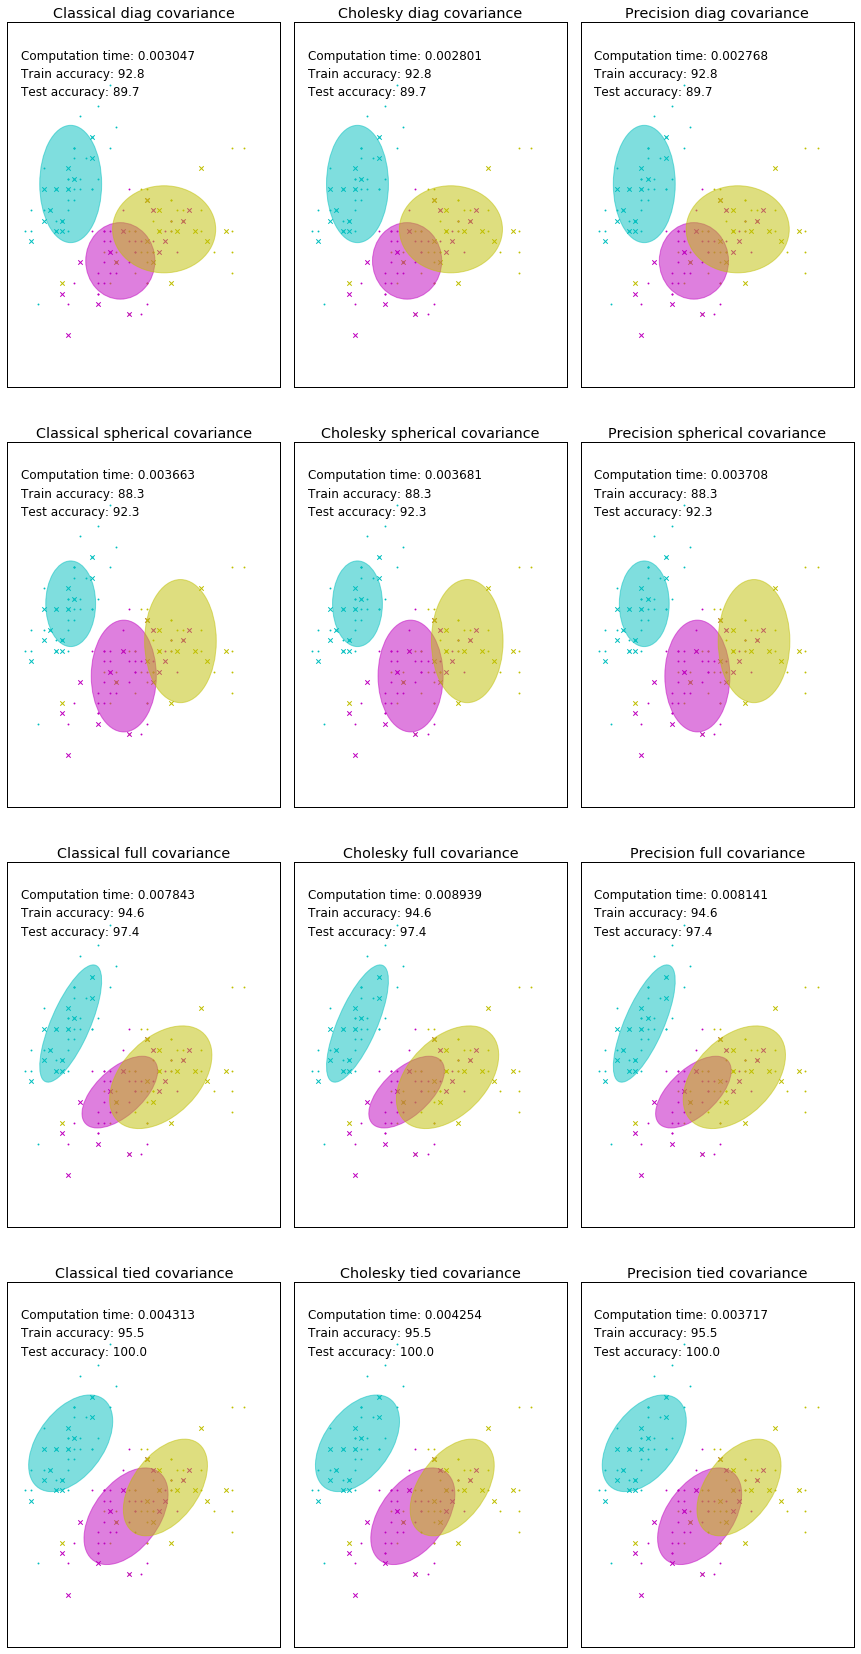

In [29]:
plt.rcParams['figure.figsize'][:] = [12, 12]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'

from time import time
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.externals.six.moves import xrange


def plot_compare(X_train, y_train, X_test, y_test, estimators):
    plt.figure(figsize=(12, 6 * len(estimators)))
    plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                        left=.01, right=.99)
    
    for index, (name, estimator) in enumerate(estimators.items()):


        # Train the other parameters using the EM algorithm.
        for k, est in enumerate(estimator):
            est.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                      for i in xrange(estimator[1].n_components)])
            computation_time = time()
            est.fit(X_train)
            computation_time = time() - computation_time
            
            h = plt.subplot(len(estimators), 3, k + 3*index + 1)
            plot_ellipses(est.means_, covariances_(est),
                          est.covariance_type if not isinstance(est, GaussianMixturePrecision) else 
                          est.precision_type, h)
            plt.text(0.05, 0.9, 'Computation time: %f' % computation_time,
                     transform=h.transAxes)
    
            for n in range(est.n_components):
                data = X_train[y_train == n]
                plt.scatter(data[:, 0], data[:, 1], s=0.8, color=colors[n],
                        label=iris.target_names[n])
            # Plot the test data with crosses
            for n in range(est.n_components):
                data = X_test[y_test == n]
                plt.scatter(data[:, 0], data[:, 1], marker='x', color=colors[n])

            y_train_pred = est.predict(X_train)
            train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
            plt.text(0.05, 0.85, 'Train accuracy: %.1f' % train_accuracy,
                     transform=h.transAxes)

            y_test_pred = est.predict(X_test)
            test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
            plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
                     transform=h.transAxes)
    
            plt.xticks(())
            plt.yticks(())
            title = ['Classical ', 'Cholesky ', 'Precision ']
            plt.title(title[k] + name + ' covariance')


# Import data
iris = datasets.load_iris()
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

# Init GMM parameters
n_components = len(np.unique(y_train))
random_state = 0
max_iter = 20
tol = 1e-3
min_covar = 0

estimators = dict((covar_type, 
                   (GaussianMixture(n_components=n_components, covariance_type=covar_type,
                                    max_iter=max_iter, reg_covar=min_covar,
                                    tol=tol, random_state=random_state),
                    GaussianMixtureCholesky(n_components=n_components, covariance_type=covar_type,
                                    max_iter=max_iter, reg_covar=min_covar,
                                    tol=tol, random_state=random_state),
                    GaussianMixturePrecision(n_components=n_components, precision_type=covar_type,
                                    max_iter=max_iter, reg_covar=min_covar,
                                    tol=tol, random_state=random_state)))
                  for covar_type in ['spherical', 'diag', 'tied', 'full']) 
plot_compare(X_train, y_train, X_test, y_test, estimators)

plt.show()

# Time benchmark
## Dimension analysis
The plot show a comparison of the different implementation of the GaussianMixture.
On the code :
- clas corresponds to the actual implementation of the GaussianMixture.
- chol corresponds to the implementation of the GaussianMixture who stores the covariance matrix as cholesky decomposition
- prec corresponds to the implementation of the GaussianMixutre who stores the precision matrix as cholesky decomposition



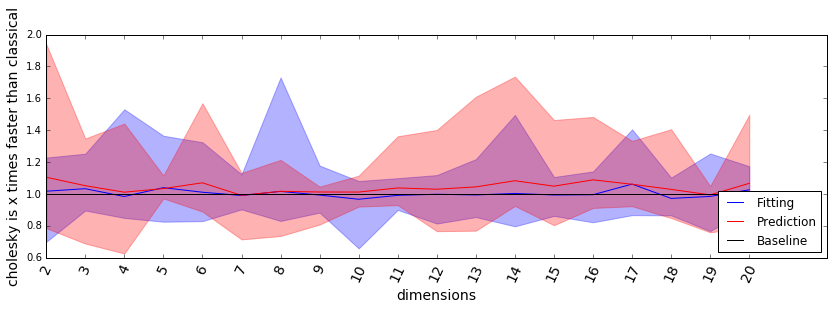

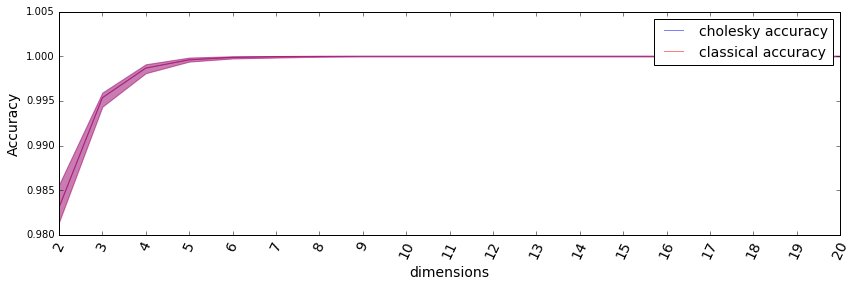

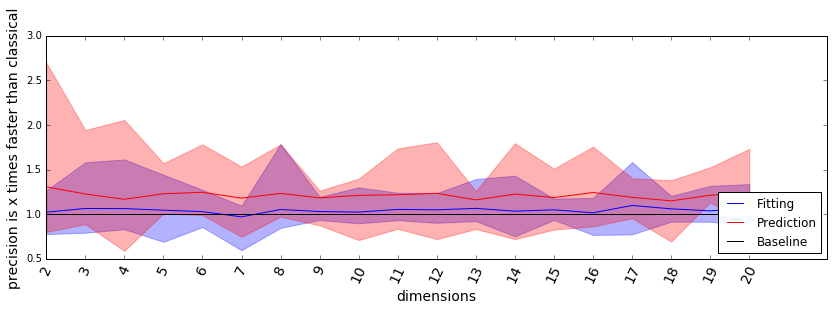

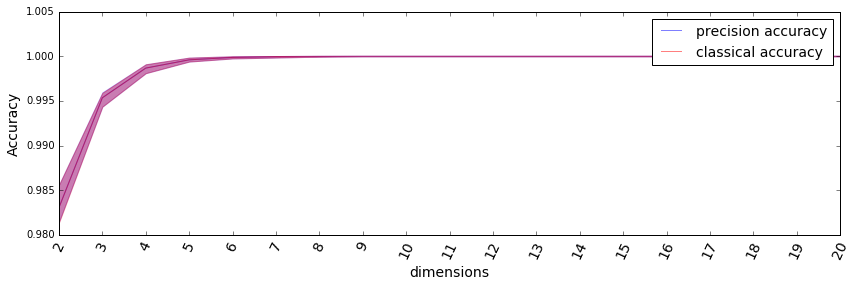

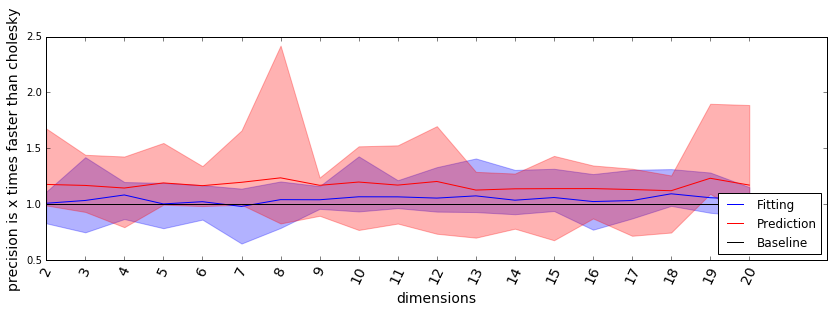

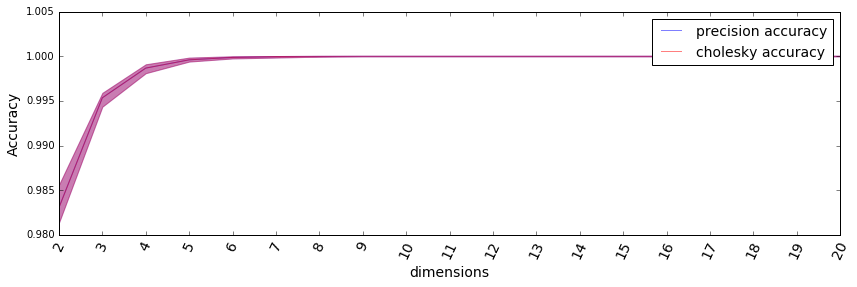

In [79]:
def create_dataset(n_samples, n_dim, n_classes):
    """Create a random dataset with n_samples in each class."""
    
    X = np.concatenate([np.random.randn(n_samples, n_dim) + i*3 for i in range(n_classes)])
    y = np.concatenate([np.zeros(n_samples) + i for i in range(n_classes)])
    return X, y

def evaluate_dimension_speeds():
    sizes = np.arange(2, 21).astype('int')
    n, m = sizes.shape[0], 20
    
    clas_predict, chol_predict, prec_predict = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_fit, chol_fit, prec_fit = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_error, chol_error, prec_error = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))

    clas = GaussianMixture(n_components=2, max_iter=1)
    chol = GaussianMixtureCholesky(n_components=2, max_iter=1) 
    prec = GaussianMixturePrecision(n_components=2, max_iter=1)
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( 10000, size, 2 )
            
            # bench fit times
            tic = time.time()
            clas.fit( X )
            clas_fit[i, j] = time.time() - tic

            tic = time.time()
            chol.fit( X )
            chol_fit[i, j] = time.time() - tic

            tic = time.time()
            prec.fit( X )
            prec_fit[i, j] = time.time() - tic            

            # bench predict times
            tic = time.time()
            clas_predictions = clas.predict( X )
            clas_predict[i, j] = time.time() - tic

            tic = time.time()
            chol_predictions = chol.predict( X )
            chol_predict[i, j] = time.time() - tic

            tic = time.time()
            prec_predictions = prec.predict( X )
            prec_predict[i, j] = time.time() - tic
            
            # check number wrong
            clas_e = (y != clas_predictions).mean()
            chol_e = (y != chol_predictions).mean()
            prec_e = (y != prec_predictions).mean()

            clas_error[i, j] = min(clas_e, 1-clas_e)
            chol_error[i, j] = min(chol_e, 1-chol_e)            
            prec_error[i, j] = min(prec_e, 1-prec_e)

    
    fit = clas_fit / chol_fit
    predict = clas_predict / chol_predict
    plot(fit, predict, clas_error, chol_error, sizes, "dimensions", "classical", "cholesky")
    
    fit = clas_fit / prec_fit
    predict = clas_predict / prec_predict
    plot(fit, predict, clas_error, prec_error, sizes, "dimensions", "classical", "precision")    

    fit = chol_fit / prec_fit
    predict = chol_predict / prec_predict
    plot(fit, predict, chol_error, prec_error, sizes, "dimensions", "cholesky", "precision")  
    
evaluate_dimension_speeds()

## Number of samples analysis

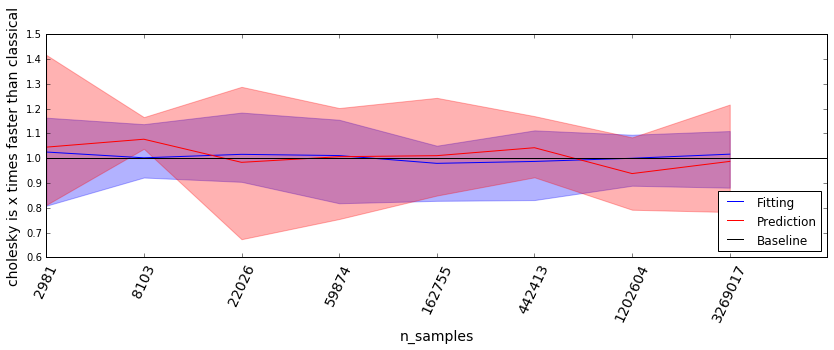

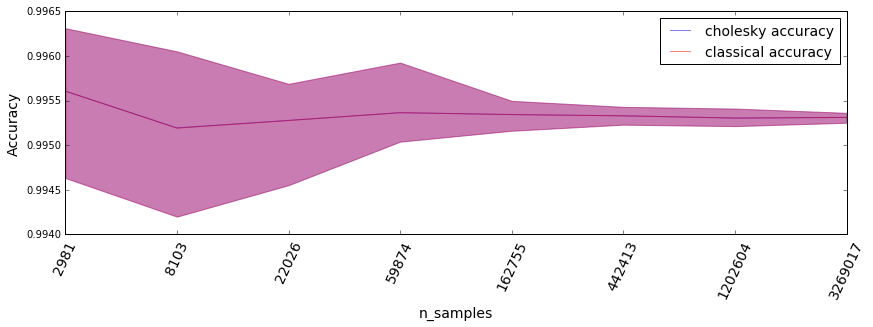

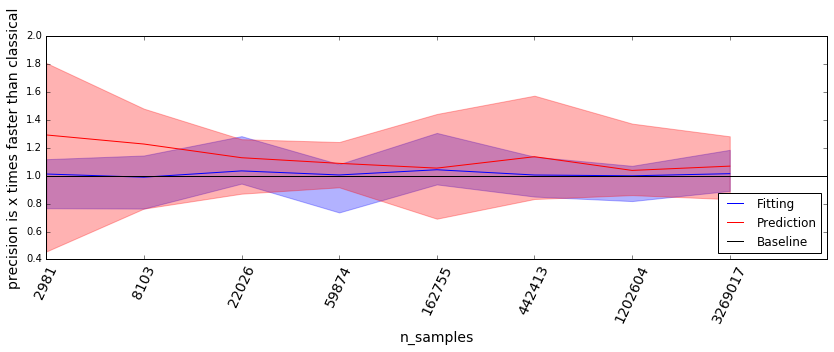

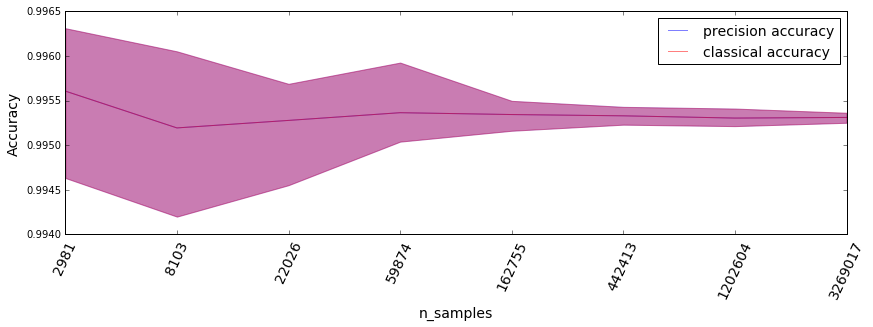

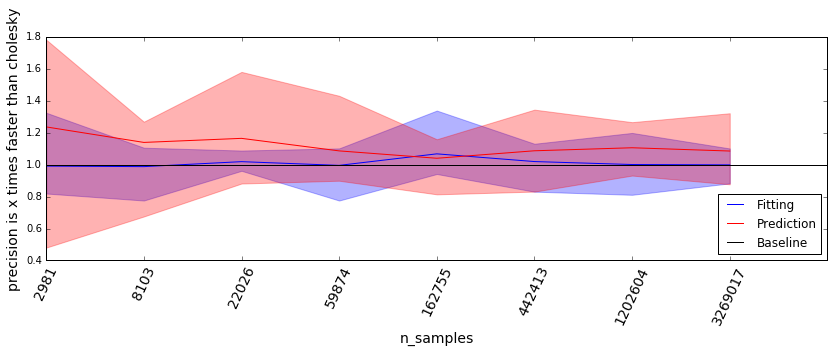

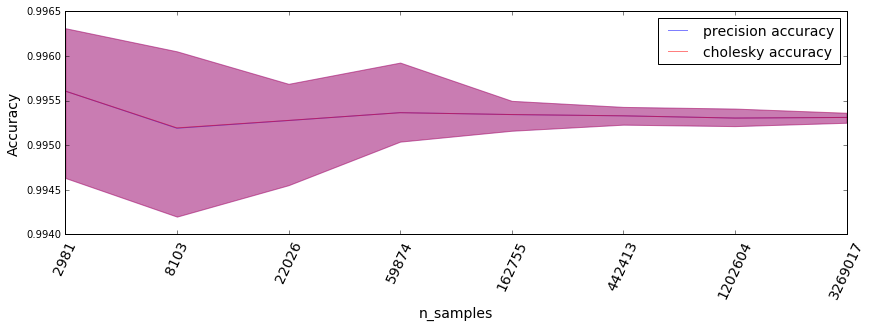

In [81]:
def evaluate_number_samples_speeds():
    sizes = np.around( np.exp( np.arange(8, 16) ) ).astype('int')    
    n, m = sizes.shape[0], 20
    
    clas_predict, chol_predict, prec_predict = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_fit, chol_fit, prec_fit = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_error, chol_error, prec_error = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))

    clas = GaussianMixture(n_components=2, tol=.1)
    chol = GaussianMixtureCholesky(n_components=2, tol=.1) 
    prec = GaussianMixturePrecision(n_components=2, tol=.1)
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 3, 2 )
            
            # bench fit times
            tic = time.time()
            clas.fit( X )
            clas_fit[i, j] = time.time() - tic

            tic = time.time()
            chol.fit( X )
            chol_fit[i, j] = time.time() - tic

            tic = time.time()
            prec.fit( X )
            prec_fit[i, j] = time.time() - tic            

            # bench predict times
            tic = time.time()
            clas_predictions = clas.predict( X )
            clas_predict[i, j] = time.time() - tic

            tic = time.time()
            chol_predictions = chol.predict( X )
            chol_predict[i, j] = time.time() - tic

            tic = time.time()
            prec_predictions = prec.predict( X )
            prec_predict[i, j] = time.time() - tic
            
            # check number wrong
            clas_e = (y != clas_predictions).mean()
            chol_e = (y != chol_predictions).mean()
            prec_e = (y != prec_predictions).mean()


            clas_error[i, j] = min(clas_e, 1-clas_e)
            chol_error[i, j] = min(chol_e, 1-chol_e)            
            prec_error[i, j] = min(prec_e, 1-prec_e)

    
    fit = clas_fit / chol_fit
    predict = clas_predict / chol_predict
    plot(fit, predict, clas_error, chol_error, sizes, "n_samples", "classical", "cholesky")
    
    fit = clas_fit / prec_fit
    predict = clas_predict / prec_predict
    plot(fit, predict, clas_error, prec_error, sizes, "n_samples", "classical", "precision")    

    fit = chol_fit / prec_fit
    predict = chol_predict / prec_predict
    plot(fit, predict, chol_error, prec_error, sizes, "n_samples", "cholesky", "precision")   
    
evaluate_number_samples_speeds()

## Number of components analysis

/home/zloten/anaconda3/envs/sklearn/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zloten/anaconda3/envs/sklearn/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


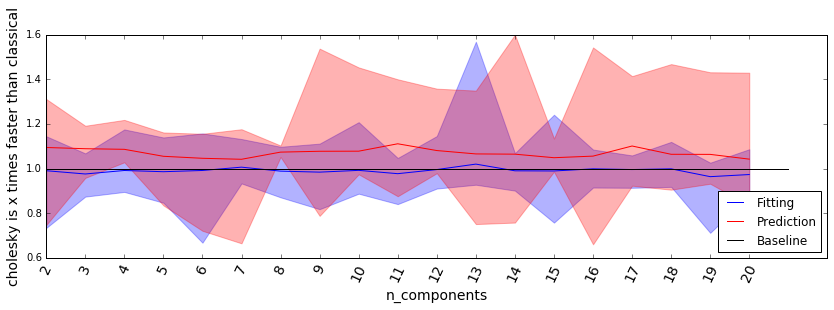

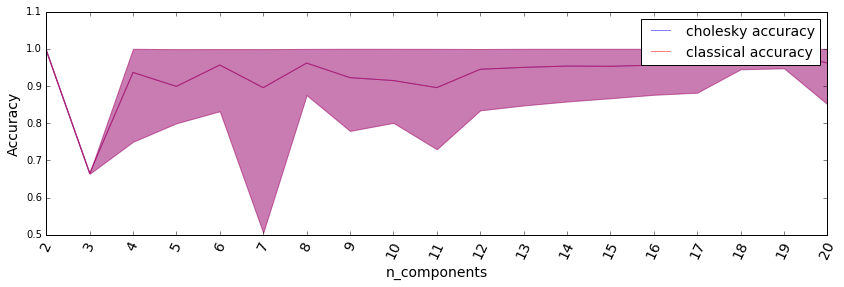

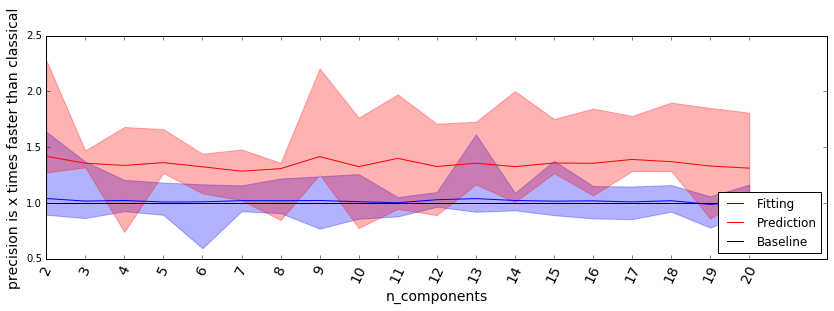

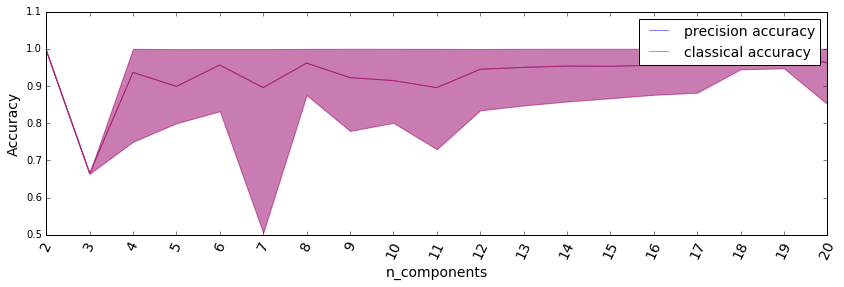

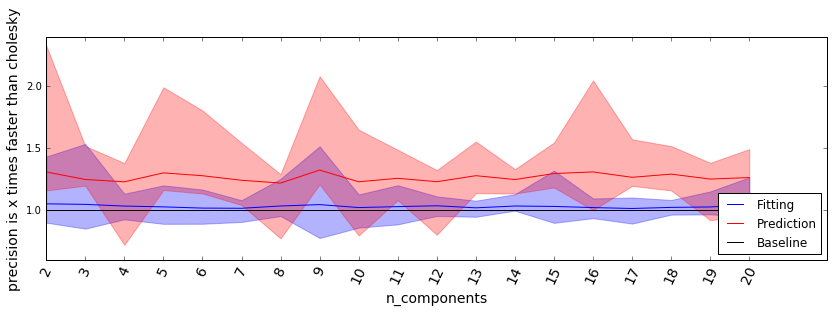

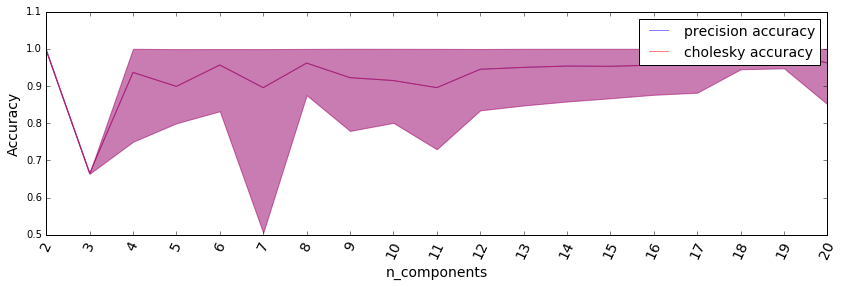

In [90]:
def evaluate_number_component_speeds():
    sizes = np.arange(2, 21, dtype='int')  
    n, m = sizes.shape[0], 20
    
    clas_predict, chol_predict, prec_predict = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_fit, chol_fit, prec_fit = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    clas_error, chol_error, prec_error = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            clas = GaussianMixture(n_components=size, max_iter=300, tol=.1, random_state=0)
            chol = GaussianMixtureCholesky(n_components=size, max_iter=300, tol=.1, random_state=0) 
            prec = GaussianMixturePrecision(n_components=size, max_iter=300, tol=.1, random_state=0)
            X, y = create_dataset( 10000/size, 3, size )
            
            # bench fit times
            tic = time.time()
            clas.fit( X )
            clas_fit[i, j] = time.time() - tic

            tic = time.time()
            chol.fit( X )
            chol_fit[i, j] = time.time() - tic

            tic = time.time()
            prec.fit( X )
            prec_fit[i, j] = time.time() - tic            

            # bench predict times
            tic = time.time()
            clas_predictions = clas.predict( X )
            clas_predict[i, j] = time.time() - tic

            tic = time.time()
            chol_predictions = chol.predict( X )
            chol_predict[i, j] = time.time() - tic

            tic = time.time()
            prec_predictions = prec.predict( X )
            prec_predict[i, j] = time.time() - tic
            
            # check number wrong
            clas_e = (y != clas_predictions).mean()
            chol_e = (y != chol_predictions).mean()
            prec_e = (y != prec_predictions).mean()


            clas_error[i, j] = min(clas_e, 1. - clas_e)
            chol_error[i, j] = min(chol_e, 1. - chol_e)            
            prec_error[i, j] = min(prec_e, 1. - prec_e)

    
    fit = clas_fit / chol_fit
    predict = clas_predict / chol_predict
    plot(fit, predict, clas_error, chol_error, sizes, "n_components", "classical", "cholesky")
    
    fit = clas_fit / prec_fit
    predict = clas_predict / prec_predict
    plot(fit, predict, clas_error, prec_error, sizes, "n_components", "classical", "precision")    

    fit = chol_fit / prec_fit
    predict = chol_predict / prec_predict
    plot(fit, predict, chol_error, prec_error, sizes, "n_components", "cholesky", "precision")
    
evaluate_number_component_speeds()